In [1]:
%load_ext autoreload
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils.utils import select_rows, polis_umap, polis_pca
from utils.clustering import plot_embedding_with_clusters, polis_kmeans_

# Visualization parameters
plt.figure(figsize=(500, 500));
sns.set_context('poster');
sns.set_style('white');
sns.set(font_scale=.7);
sns.set_color_codes();
np.seterr(divide='ignore', invalid='ignore');

<Figure size 36000x36000 with 0 Axes>

# Import data

In [2]:
# Import participants votes
df = pd.read_csv('Data/american-assembly.bowling-green/participants-votes.csv',index_col='participant')
df.head(3)

,group-id,n-comments,n-votes,n-agree,n-disagree,0,1,2,3,4,...,886,887,888,889,890,891,892,893,894,895
participant,,,,,,,,,,,,,,,,,,,,,
0,0.0,92,610,397,100,-1.0,-1.0,1.0,1.0,1.0,...,NaN,NaN,1.0,NaN,1.0,1.0,NaN,1.0,1.0,1.0
2,0.0,0,29,23,6,-1.0,1.0,1.0,-1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0,29,20,6,-1.0,1.0,1.0,-1.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Import participants' comments
df_comments = pd.read_csv('Data/american-assembly.bowling-green/comments.csv',index_col='comment-id')
df_comments.index = df_comments.index.astype(str)
df_comments.head(3)

,timestamp,datetime,author-id,agrees,disagrees,moderated,comment-body
comment-id,,,,,,,
895,1518501496471,Tue Feb 13 12:58:16 WIB 2018,1756,48,8,1,Smallhouse Rd (at Campbell Ln) heading into to...
894,1518499107516,Tue Feb 13 12:18:27 WIB 2018,1480,27,16,1,Doctors should not overreact to the opioid cri...
893,1518498500733,Tue Feb 13 12:08:20 WIB 2018,1751,33,18,1,More free meeting space for nonprofits.


In [4]:
# Set Metadata fields and variable fields
metadata_fields = ['group-id', 'n-comments', 'n-votes', 'n-agree', 'n-disagree']
val_fields = [c for c in df.columns.values if c not in metadata_fields]

# remove statements (columns) which were moderated out
# df_comments["moderated"] = 0   --->   comment should be removed
statements_all_in = sorted(list(df_comments.loc[df_comments["moderated"] > 0].index.array), key = int)

# Remove participants with less than N (threshold) votes.
df = select_rows(df=df, val_fields=val_fields, threshold=60)

# Preprocess
metadata = df[metadata_fields]
vals = df[val_fields]
# If the participant didn't see the statement, it's a null value, here we fill in the nulls with zeros
vals = vals.fillna(0)
vals = vals.sort_values("participant")

## Overall statistics

In [5]:
melted = vals.melt();
all_votes = melted.count();
by_type = melted["value"].value_counts();
total_possible_votes = all_votes["value"];
total_agrees = by_type[1.0];
total_disagrees = by_type[-1.0];
total_without_vote = by_type[0.0];

print("Dimensions of matrix:", df.shape)
print("Dimensions of matrix:", vals.shape)
print("Total number of possible votes:", total_possible_votes)
print("Total number of agrees:", total_agrees)
print("Total number of disagrees:", total_disagrees)
print("Total without vote:", total_without_vote)
print("Percent sparse: ", total_without_vote / total_possible_votes,"%")

## Make sure to check how many people and votes, relative to the total matrix, you are losing given min vote threshold

Dimensions of matrix: (1006, 901)
Dimensions of matrix: (1006, 896)
Total number of possible votes: 901376
Total number of agrees: 100041
Total number of disagrees: 35177
Total without vote: 766158
Percent sparse:  0.8499871307867083 %


## Comment & participant selection

In [6]:
vals_all_in = vals[statements_all_in]

# Opinion groups

To form opinion groups, we take the PCA coordinates and perform K-means clustering with K=100. 
These fine-graine cluster serve as the basis for a more coarse-grained clustering, also using K-means. 
<font color='red'>
*In fact, we take the 100 centers (obtained from the first K-means clustering), and run additional K-means clustering for K ranging between 2 and 5.*
</font>
The K for which the silhoutte coefficient (a measure of withing-cluster similarity vs. between-cluster dissimilarity) is optimal is chosen for the opinion groups.

Explained variance: [0.12267305 0.06782146]
Plotting PCA embeddings with K-means, K=50
Optimal clusters for K = 2
Plotting PCA embeddings with K-means, K=2


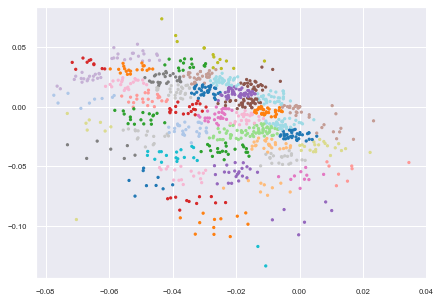

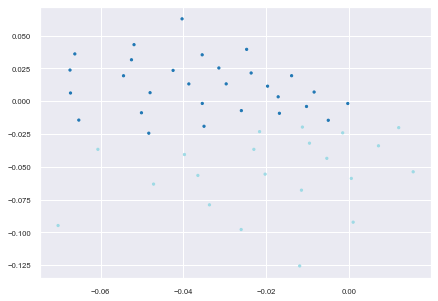

In [7]:
# Methodology: 
# 1. Apply PCA on opinion matrix
# 2. Partition participants in 100 clusters and get 'cluster_centers'
# 3. Partition 'cluster_centers' in K clusters (optimal based on silhoutte score)
# 4. Based on clustered 'cluster_centers' assign each participant in the cluster group ('clusters_star')
    


# Step 1 - get PCA clusters 
embedding, explained_variance = polis_pca(vals_all_in, 2)  
print("Explained variance:", explained_variance)

# Step 2 - K-means with K=100
clusters_100, centers = polis_kmeans_(embedding, n_clusters=50)
plot_embedding_with_clusters(embedding, clusters_100)

# Step 3 - find optimal K
from sklearn.metrics import silhouette_score 
silhoutte_star = -np.inf
for K in range(2,6):
    clusters_K, _ = polis_kmeans_(centers,n_clusters=K)
    silhouette_K = silhouette_score(centers, clusters_K)
    if silhouette_K >= silhoutte_star:
        K_star = K
        silhoutte_star = silhouette_K
        clusters_K_star = clusters_K
print('Optimal clusters for K =',str(K_star))
plot_embedding_with_clusters(centers, clusters_K_star)
 
# Step 4 - assign each voter to "optimal" cluster
clusters_star = np.zeros(len(clusters_100))
for k in range(50):#
    #find all indices with clusters k and assign them new star label
    clusters_star[np.where(clusters_100==k)]  = clusters_K_star[k]



# Comment Statistics

We analyze comments for how strongly they represent each opinion group.
For that, the representative metric R_v(g,c) is calculated for all groups g, comments c, and possible votes v.
This metric estimates how much more likely participants in group g are vote v on said comment c than those outside group g.

*Definition of R_v(g,c):*
Let N_v(g,c) be the number of participants in group g who cast vote v on comment c, and let N(g,c)   be the total number of votes for comment c within group g (i.e. <font color='red'> N_{+1}(g,c)+  N_{-1}(g,c) <font> )

Defifne P_v(g,c)=(1+N_v(g,v))/(2+N(g,c)) which estimates the probability that a given person in group g votes v on comment c. Then

R_v(g,c) = P_v(g,c)/ P_v(g_not,c)

where g_not denotes the complement of g, thus all participants not in g.

In [8]:
# Step 1: Calculate N_v(g,c), N(g,c), and P_v(g,c)
# - 𝑁𝑣(𝑔,𝑐) be the number of participants in group g who cast vote v on comment c
# - 𝑁(𝑔,𝑐) be the total number of votes on comment c within group g
# - 𝑃𝑣(𝑔,𝑐) is an estimate of the probability that a given person in group g votes v on said comment

N_groups, N_comments = K_star, len(statements_all_in)
N_v_g_c = np.zeros([3,N_groups,N_comments]) #create N matrix 
P_v_g_c = np.zeros([3,N_groups,N_comments])
N_g_c = np.zeros([N_groups,N_comments])
v_values = [-1,0,1]

for g in range(N_groups): 
    idx_g = np.where(clusters_star == g)[0] #get indices of cluster g; caution_ idx != participant id
    for c in range(N_comments):
        comment = statements_all_in[c] #comment id
        df_c = vals_all_in[str(comment)].iloc[idx_g] #data frame: [participants of group g, comment c], 
        for v in range(3):
            v_value = v_values[v]
            N_v_g_c[v,g,c] = (df_c == v_value).sum() #counts all v_value votes in data frame df_c
        N_g_c[g,c] = N_v_g_c[0,g,c] + N_v_g_c[2,g,c] #total votes corresponds to votes with +1 or -1  
        
        for v in range(3):
            P_v_g_c[v,g,c] = (1 + N_v_g_c[v,g,c]) / (2 + N_g_c[g,c])
        
# Step2: calculate R_v(g,c)
# 𝑅𝑣(𝑔,𝑐) resentativeness of comment c in group g and vote v estimates how much more likely participants 
# in group g are to vote v on said comment than those outside group g.            
R_v_g_c = np.zeros([3, N_groups, N_comments])
for g in range(N_groups): 
    for c in range(N_comments):
        for v in range(3):
           R_v_g_c[v,g,c] = P_v_g_c[v,g,c] / np.delete(P_v_g_c[v,:,c],g,0).sum()  # np.delete neglects all entries with group g                                           
                                                   


## Comment Selection criterion

Given R_v(g,c), how to decide weather comment c is representative for group g?

Remember: R_v(g,c)=2 means that comment c is 2 times more likely to be voted v in group g compared to all the other groups. 
However, this does not tell us how significant this difference is (a very small likelihood multiplied by 2 is still a very small likelihood).

<font color='red'> 
As a measure of significance, we calculate the Fisher exact test. This quantity can be regarded as a measure of correlation between two random variables. In fact, it tests how significantly the obtained sample (in this case votes v of comment c in group g) is different from the 0 hypothesis (in this case, that votes v are drawn from a hypergeometric distribution with parameters given by including all groups on comment c). 
<font>

We weight this significance measure with R_v(g,c).

In [9]:
import scipy.stats as stats
from scipy.stats import hypergeom

v_values = [-1, 0, 1]
p_values = np.zeros([N_groups, N_comments, 3])

for g in range(N_groups): 
    idx_g = np.where(clusters_star == g)[0] # get indices of cluster g; caution_ idx != participant id
    idx_g_not = np.where(clusters_star != g)[0] # get indices of rest
    for c in range(N_comments):
        comment = statements_all_in[c] # comment id
        
        for v in range(3):            
            v_value = v_values[v]
            N_v = (vals_all_in[str(comment)] == v_value).sum()    # total number of v votes in comment c
            N_rest = (vals_all_in[str(comment)]).count() - N_v    # total number of votes =  number of participants
            
            df_c = vals_all_in[str(comment)].iloc[idx_g]  # get data frame of group g for comment c
            N_v_in_g = (df_c == v_value).sum()
            N_g = (df_c).count()   
            
            [M, n, N] = [N_rest+N_v, N_v, N_g]  # hypergeometric distribution parameters https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.hypergeom.html
            x = range(N_v_in_g-1 ,N_g+1)
            prb = hypergeom.pmf(x, M, n, N).sum() #calculates P(X >= N_v_in_g), i.e. p-value. 
            p_values[g,c,v] = prb * R_v_g_c[v,g,c]

In [10]:
## Lets print the most significant (negative) comments for each group!
for g in range(N_groups): 
    idx_ = np.argsort(p_values[g,:,0]) #take only the significant comments
    print('-----------------------------------')
    print('Top-5 significant comments for group ', g, '(negative)')
    print('-----------------------------------')
    for i in range(5):
        print(' - ', df_comments['comment-body'][idx_[i]])
    print()

-----------------------------------
Top-5 significant comments for group  0 (negative)
-----------------------------------
 -  City and County should convert existing street lighting to Dark Sky Complaint Lights. #Nomoreorangeglow
 -  where do we go for shelter in case of tornado alert in my part of town .cabell dr neighbehood
 -  Planning and zoning laws should change to encourage small businesses and farms.
 -  Museums would be beneficial to BG/Warren County residents, and also bring in tourists from surrounding counties.
 -  Emphasize that ALL immigrants should learn and speak ENGLLISH.

-----------------------------------
Top-5 significant comments for group  1 (negative)
-----------------------------------
 -  Older apartment complexes deteriorate.  Creates blighted areas, crime increases.  Stricter Landlord/Tenant rules needed!
 -  Drivers Education classes should be required for new drivers before you can get a permit or license.
 -  Businesses and multi-family dwellings should 

In [11]:
## Lets print the most significant (positive) comments for each group!
for g in range(N_groups): 
    idx_ = np.argsort(p_values[g,:,2]) #take only the significant comments
    print('-----------------------------------')
    print('Top-5 significant comments for group ', g, '(positive)')
    print('-----------------------------------')
    for i in range(5):
        print(' - ', df_comments['comment-body'][idx_[i]])
    print()

-----------------------------------
Top-5 significant comments for group  0 (positive)
-----------------------------------
 -  Older apartment complexes deteriorate.  Creates blighted areas, crime increases.  Stricter Landlord/Tenant rules needed!
 -  Drivers Education classes should be required for new drivers before you can get a permit or license.
 -  Businesses and multi-family dwellings should be required to offer and use recycling services.
 -  Raise drivers license from 16 to 18 and IMPROVE DRIVERS ED CLASSES in High schools  Believe me they are pitiful.
 -  Provide accessible transportation for seniors that have difficulty driving

-----------------------------------
Top-5 significant comments for group  1 (positive)
-----------------------------------
 -  where do we go for shelter in case of tornado alert in my part of town .cabell dr neighbehood
 -  City and County should convert existing street lighting to Dark Sky Complaint Lights. #Nomoreorangeglow
 -  Museums would be be